Neural network classification. With XGBoost.

Done!
Final accuracy on the test data: 81.2%
Accuracy of Neural network with XGBoost: 78.6%


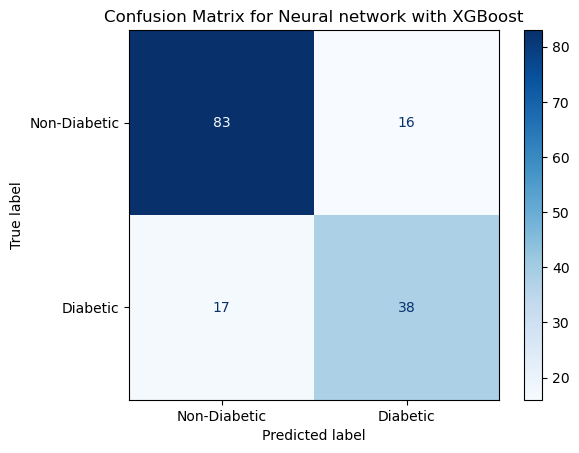

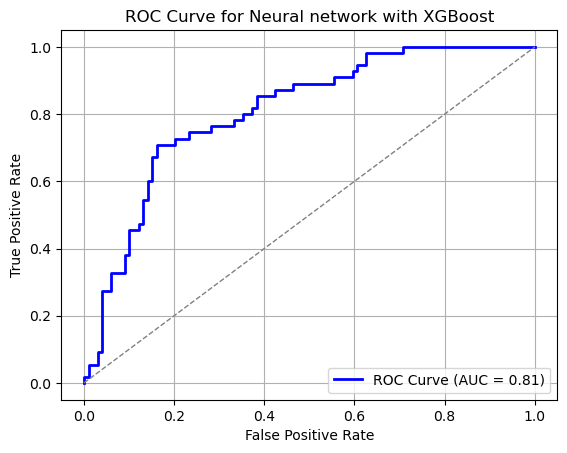

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

# Set seed to make reproducible
torch.manual_seed(2024)

# Read in dataset
df = pd.read_csv("diabetes_preprocessed.csv")
# Separate features and target variable
X = df.drop(columns="Outcome").values  # 'Outcome' is the target variable
y = df["Outcome"].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long for classification labels
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader 
training_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(training_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

# Define the architecture of our Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.output = nn.Linear(hidden_size3, output_size)
        self.ReLU = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()

    def forward(self, x, return_features=False):
        x = self.ReLU(self.fc1(x))  # First hidden layer
        x = self.ReLU(self.fc2(x))
        x = self.ReLU(self.fc3(x))
        features = x  # Want to extract this for XGBoost before classification
        x = self.leakyrelu(self.output(x))  # Output layer
        if return_features:
            return x, features
        else:
            return x

input_size = X_train.shape[1]
hidden_size1 = 12
hidden_size2 = 8
hidden_size3 = 10
output_size = 2

model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

learning_rate = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

def train_loop(dataloader, model, loss_function, optimizer):
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X, return_features=False)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_loop(dataloader, model, loss_function):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    predictions = []
    classifications = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X, return_features=False)
            test_loss += loss_function(pred, y).item()
            predictions.extend(pred.argmax(1).tolist())
            classifications.extend(y.tolist())
            
    accuracy = accuracy_score(classifications, predictions)
    test_loss /= num_batches
    return predictions, classifications, accuracy

epochs = 350
best_accuracy = 0
best_model_state = None

for epoch in range(epochs):
    train_loop(train_loader, model, loss_function, optimizer)
    predictions, classifications, accuracy = test_loop(test_loader, model, loss_function)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict()  # Save the state of the model

print("Done!")

print(f"Final accuracy on the test data: {100*(best_accuracy):>0.1f}%")

# Load the best model state
model.load_state_dict(best_model_state)

# Extract features using the best model state
model.eval()
with torch.no_grad():
    _, train_features = model(X_train_tensor, return_features=True)
    _, test_features = model(X_test_tensor, return_features=True)

# Convert torch tensor to numpy array
train_features_np = train_features.numpy()
test_features_np = test_features.numpy()

# XGBoost Implementation
# Create the XGBoost model
xgb_model = xgb.XGBClassifier()

# Train the XGBoost model using features from the neural network
xgb_model.fit(train_features_np, y_train)

# Predict on the test data using trained XGBoost model
xgb_predictions = xgb_model.predict(test_features_np)

# Accuracy of the XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"Accuracy of Neural network with XGBoost: {100 * (xgb_accuracy):>0.1f}%")

# Generate and plot the confusion matrix for XGBoost
xgb_conf_matrix = confusion_matrix(y_test, xgb_predictions)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_conf_matrix, display_labels=['Non-Diabetic', 'Diabetic'])
xgb_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Neural network with XGBoost")
plt.show()

# ROC AUC Plot for XGBoost
xgb_pred_prob = xgb_model.predict_proba(test_features_np)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_pred_prob)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

# Plot the ROC curve for XGBoost
plt.figure()
plt.plot(xgb_fpr, xgb_tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {xgb_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Neural network with XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()